# Train a Model to Detect Breast MRI tumors with Deep Learning and PyTorch
## Introduction

Deep learning and neural networks have produced strong results for challenging computer vision tasks such as image classification and object detection, and it is easier than ever to get started with deep learning with just a rudimentary knowledge of Python, thanks to libraries such as PyTorch. Of course, the applications of deep learning are not just limited to basic natural image tasks; many other fields have benefited from neural networks, such as the key application area of *medical imaging and computer-assisted diagnosis*. In this tutorial, I will show how to use deep learning for a medical imaging classification task on a real dataset of breast cancer MR (magnetic resonance) scans, from start to finish using Python. 

All code can be found at [github.com/mazurowski-lab/MRI-deeplearning-tutorial](https://github.com/mazurowski-lab/MRI-deeplearning-tutorial). This code is partially based on the [code](https://github.com/mazurowski-lab/radiologyintrinsicmanifolds) from my MICCAI 2022 paper "The Intrinsic Manifolds of Radiological Images and their Role in Deep Learning", another example of how I've studied deep learning on medical images.

For the first part of this blog series, I will introduce the standard data type of medical images, DICOM files (Digital Imaging and Communications in Medicine), and show how to obtain the MRI DICOM data. Next, I will show how to use Python to interact with the data, and convert it to a format easily usable for deep learning. 

The second part of this series will describe how to use PyTorch to create a neural network for image classification, and create a model training and evaluation pipeline that uses this data for the cancer detection task.

## Prerequisites

Basic Python knowledge is needed for this tutorial, and basic experience with PyTorch will be helpful; PyTorch's [60-minute blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) is a great place to start.

# Part 0: Setup
## Requirements
You will need the following libraries installed for Python 3:
1. PyTorch (`torch` and `torchvision`) (see [here](https://pytorch.org/get-started/locally/))
2. `pandas`
3. `numpy`
4. `scikit-image`
5. `pydicom`
6. `tqdm`
7. `matplotlib`

# Part I: Preparing The Data
## (1) Download the data

For this tutorial we will use my lab's Duke-Breast-Cancer-MRI (DBC-MRI) dataset, a dataset of breast MR scans from 922 subjects at Duke University (see the paper [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6134102/) for more information). We will be using about one tenth of the full dataset, due to its large size. The first step is to download the data, which can be obtained from The Cancer Imaging Archive (TCIA). Please refer to the following instructions to do this.
1. Travel to the TCIA homepage of DBC-MRI [here](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226903), and scroll down to the "**Data Access**" tab. 
2. Download the data annotation (breast tumor bounding boxes) and filepath list files "File Path mapping tables (XLSX, 49.6 MB)" and "Annotation Boxes (XLSX, 49 kB)" from the second and fourth rows of the table, respectively. You'll then need to convert these to `.csv` manually (e.g. using Microsoft Excel). Move these into your working directory.
3. In the first row of the table, go to the column "**Download all or Query/Filter**", and click the "**Search**" button to go to a page where you can select a subset of the dataset for download.
4. Skip any tutorial prompts here. Next, make sure you're under the "Search Results" tab, and scroll to the bottom of this table and modify "Show xxx entries" to show 100 entries. Your screen should look something like this:
![TCIA data selection screenshot.](imgs/screenshot_TCIA.png)
5. Next, click the shopping cart icon between "**Cart**" and "**Collection ID**" on the table header to select all 100 entries.
6. With the data selected and added to your cart, click the "Cart" tab on the top right of the page (it should also say "36 GB") to go to your cart.
7. Now on the cart page, click "Download" right below the "Cart" tab to download a `.tcia` file that will be used to download your data. You can now close the page.
8. In order to download the dataset (subset) to your computer with the `.tcia` file, you'll need to use TCIA's NBIA Data Retreiver tool, which can be obtained [here](https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images). Once installed (see the Data Retreiver page for more details), open the downloaded `.tcia` file with the data retreiver tool.
9. Download all files, and **make sure that you download them with the "Classic Directory Name" directory type convention**, otherwise the following data preprocessing code will not work. This will take some time; if the downloads ever halt, resume by performing the same start procedure (the data retreiver program will detect which files have already been downloaded.)
10. Once completed, all DICOM files will be in a folder named `manifest-xxx`, where `xxx` is some string. This manifest folder may be within a few subfolders. Move this manifest folder into your working directory.
11. Proceed to the following section to see how we will process this data for usage with a neural network.

## (2) Process the data for training
To start working with the data, let's begin by importing a few libraries into your Python environment (`.py` script, `.ipynb` notebook, etc.):

In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave

Next, let's begin by defining a few useful filepaths:

In [2]:
data_path = 'manifest-1655917758874'
boxes_path = 'Annotation_Boxes.csv'
mapping_path = 'Breast-Cancer-MRI-filepath_filename-mapping.csv'
target_png_dir = 'png_out'
if not os.path.exists(target_png_dir):
	os.makedirs(target_png_dir)


Here, `data_path` needs be changed to the name string of your downloaded manifest folder (`manifest-xxx`), as it's likely different from mine. The variable `boxes_path` is the path of the file containing cancer annotation bounding boxes, `mapping_path` is the path of the file that lists where each image is located, and target_png_dir is the new directory that will be created where we will output `.png` images files extracted from the DICOMs.

Next, let's load the bounding box annotation list and see what it looks like:

In [3]:
boxes_df = pd.read_csv(boxes_path)
display(boxes_df)

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
917,Breast_MRI_918,345,395,338,395,62,85
918,Breast_MRI_919,285,312,369,397,98,109
919,Breast_MRI_920,172,193,337,355,87,101
920,Breast_MRI_921,328,374,404,446,97,121


Note that these MRIs are three-dimensional: they have coordinates of height (measured by pixel rows), width (measured pixel columns), and depth (measured by the "slice" dimension). Here, **Start Row**, **End Row**, **Start Column** and **End Column** define the two-dimensional bounding box areas along the height-width pixel dimension where a tumor was found for each patient, while **Start Slice** and **End Slice** describe how far the bounding box/tumor extends in the depth (slice) dimension.

For simplicity, we will only consider fat-saturated MR exams: this can be accomplished by loading the image filepath `.csv` list, and only keeping the subset of fat-saturated images:

In [4]:
# only consider fat-satured "pre" exams
mapping_df = pd.read_csv(mapping_path)
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('pre')]

# remove entries from patients that we are not including (we only include patients 1 to 100)
# using a regex pattern
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 101))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Note that each row in `mapping_df` refers to a different 2D slice of a full 3D MRI *volume*.

Next, we are ready to write some code to automatically extract `.png` files from the raw DICOM data, as `.png` work nicely with PyTorch (and take up much less space than DICOMs). First, however, we need to *define our classification task*, as the labels that we will assign to each extracted `.png` image are based off of this task definition. 

### Defining our task
A straightforward task is simply to train a classification model to detect for the presence of cancer within breast MRI slices; by convention, we will take all 2D slices that contain a tumor bounding box to be **positive**, (labeled with "**1**"), and all other slices at least five slices away from positive slices to be **negative** ("**0**").

Before we write our `.png` extraction code, we will need to write a helper function for saving a single 2D slice `.png` image of a 3D MRI (each DICOM file contains a single slice). This function, which we will name `save_dcm_slice()`, will take three arguments: 
1. `dcm_fname`, the filename of the source DICOM,
2. `label`, the cancer label of that slice, either `0` for negative or `1` for positive, and
3. `vol_idx`, the patient number/index of the MRI out of the entire dataset.

This function can be written with the following code, which I comment to explain each step (including some additional necessary preprocessing)

In [5]:
def save_dcm_slice(dcm_fname, label, vol_idx):
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    png_path = dcm_fname.split('/')[-1].replace('.dcm', '-{}.png'.format(vol_idx))
    label_dir = 'pos' if label == 1 else 'neg'
    png_path = os.path.join(target_png_dir, label_dir, png_path)

    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))
    
    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist (if you're running this after the first time)
        
        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split('/')
            dcm_fname_end = dcm_fname_split[-1]
            assert dcm_fname_end.split('-')[1][0] == '0'
            
            dcm_fname_end_split = dcm_fname_end.split('-')
            dcm_fname_end = '-'.join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])
            
            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = '/'.join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)
            
        
        # convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(np.float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)

        # save final .png
        imsave(png_path, img)

Next, when converting each 2D slice to a `.png`, we'll want to iterate over each 3D patient volume, as each volume is associated with a single breast tumor bounding box, as is all 2D slices (DICOMs) within that volume. 

It is also important that the network is trained on a dataset that has a balanced amount of positive and negative class examples, so that it doesn't focus too heavily on one of the two classes (see our paper [here](https://www.sciencedirect.com/science/article/pii/S0893608018302107) for further discussion on the class imbalance problem). In total, we could extract a bit more than 2600 positive images from this dataset, and about 13500 negatives. As such, to maintain a class balance, we will extract exactly 2600 of each class.

This can be accomplished with the following code that iterates through `mapping_df` (the conversion will take some time):

In [6]:
# number of examples for each class
N_class = 2600
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(mapping_df.iterrows(), total=N_class*2):
	# indices start at 1 here
	new_vol_idx = int((row['original_path_and_filename'].split('/')[1]).split('_')[-1])
	slice_idx = int(((row['original_path_and_filename'].split('/')[-1]).split('_')[-1]).replace('.dcm', ''))

	# new volume: get tumor bounding box
	if new_vol_idx != vol_idx:
		box_row = boxes_df.iloc[[new_vol_idx-1]]
		start_slice = int(box_row['Start Slice'])
		end_slice = int(box_row['End Slice'])
		assert end_slice >= start_slice
	vol_idx = new_vol_idx

	# get DICOM filename
	dcm_fname = str(row['classic_path'])
	dcm_fname = os.path.join(data_path, dcm_fname)
	
	# determine slice label:
	# (1) if within 3D box, save as positive
	if slice_idx >= start_slice and slice_idx < end_slice: 
		if ct_positive >= N_class:
			continue
		# dcm = load_dcm(dcm_fname)
		save_dcm_slice(dcm_fname, 1, vol_idx)
		ct_positive += 1

	# (2) if outside 3D box by >5 slices, save as negative
	elif (slice_idx + 5) <= start_slice or (slice_idx - 5) > end_slice:
		if ct_negative >= N_class:
			continue
		save_dcm_slice(dcm_fname, 0, vol_idx)
		ct_negative += 1

  0%|          | 0/5200 [00:00<?, ?it/s]/var/folders/gf/22jnxb857t36jfl3k94p9kj80000gn/T/ipykernel_37857/3333985462.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = img.astype(np.float) * 255. / img.max()
17116it [00:01, 9901.38it/s]                         


### 

Now let's see what one of these images looks like. We'll display a random positive (cancer) image (ran in a Jupyter notebook):

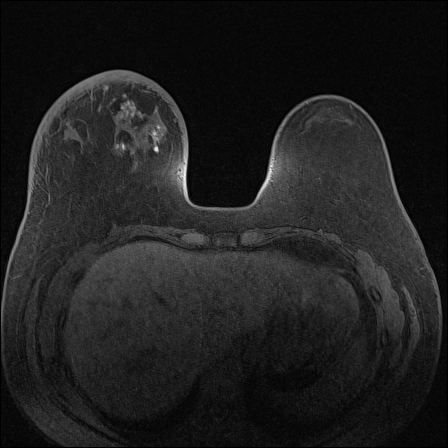

In [7]:
from IPython.display import Image, display
from random import choice

positive_image_dir = os.path.join(target_png_dir, 'pos')
negative_image_filenames = os.listdir(positive_image_dir)
sample_image_path = os.path.join(positive_image_dir, choice(negative_image_filenames))

display(Image(filename=sample_image_path))





That's it for this tutorial! We are now ready to train and test a neural network to detect the presence of cancer with this data. Please proceed to the following tutorial, where I show (1) how to create a PyTorch data loading pipeline for network training and evaluation and (2) how to load, train and test a classification network with this data.